# 0. GPU

In [2]:
import numpy as np
import cv2, os, glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf1


os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf1.Session(config=config)

2024-11-29 08:45:22.061355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20169 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


# 1. 데이터 불러오기
* Size = (240, 240)로 고정되어 있고
* 기존 데이터에 추가로 데이터 증강하여 총 2000개의 npy 파일 불러오기

In [62]:
Fractured = np.load("./augmented_data/augmented_images.npy")
Mask = np.load("./augmented_data/augmented_masks.npy")

print("Fractured Shape :", Fractured.shape)
print("Mask Shape :", Mask.shape)

Fractured Shape : (2000, 240, 240, 1)
Mask Shape : (2000, 240, 240, 1)


# 2. 정규화(Normalization)
* 각 픽셀값을 255로 나누어 0 ~ 1 사이의 범위로 스케일링 하여 모델이 학습하기 쉽게 만들어 주는 과정

In [63]:
Fractured = Fractured / 255.0

# 데이터 전처리
* [의료 영상(X-ray 이미지) 전처리, 가공 및 특징점 검출 논문](https://www.dbpia.co.kr/pdf/pdfView.do?nodeId=NODE10591699&googleIPSandBox=false&mark=0&minRead=5&ipRange=false&b2cLoginYN=false&icstClss=010000&isPDFSizeAllowed=true&accessgl=Y&language=ko_KR&hasTopBanner=true)
* Canny
* Otsu
* TSMO

In [90]:
import numpy as np
from skimage import feature
from skimage.filters import threshold_otsu, threshold_local

# Function to apply Canny edge detection to all images in a dataset
def apply_canny_to_dataset(dataset, sigma=1.0):
    canny_edges = np.zeros_like(dataset)  # Create an empty array to store edges
    for i in range(dataset.shape[0]):
        canny_edges[i, :, :, 0] = feature.canny(dataset[i, :, :, 0], sigma=sigma)
    return canny_edges

# Function to apply Otsu's thresholding to all images in a dataset
def apply_otsu_to_dataset(dataset):
    otsu_transformed = np.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        image = dataset[i, :, :, 0]
        thresh = threshold_otsu(image)  # Compute Otsu's threshold
        otsu_transformed[i, :, :, 0] = image > thresh  # Apply threshold
    return otsu_transformed

# Function to apply TSMO (adaptive thresholding) to all images in a dataset
def apply_tsmo_to_dataset(dataset, block_size=21, offset=5):
    tsmo_transformed = np.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        image = dataset[i, :, :, 0]
        adaptive_thresh = threshold_local(image, block_size=block_size, offset=offset)
        tsmo_transformed[i, :, :, 0] = image > adaptive_thresh  # Apply adaptive threshold
    return tsmo_transformed

# Load your dataset
# Replace the path with the actual location of your augmented_images.npy file
Fractured = np.load("./augmented_data/augmented_images.npy")

# Apply transformations to the dataset
canny_images = apply_canny_to_dataset(Fractured, sigma=1.0)
otsu_images = apply_otsu_to_dataset(Fractured)
tsmo_images = apply_tsmo_to_dataset(Fractured, block_size=35, offset=10)

# Save the transformed datasets as .npy files
np.save("./augmented_data/canny_images.npy", canny_images)
np.save("./augmented_data/otsu_images.npy", otsu_images)
np.save("./augmented_data/tsmo_images.npy", tsmo_images)

print("Canny, Otsu, and TSMO transformations have been saved successfully.")


Canny, Otsu, and TSMO transformations have been saved successfully.


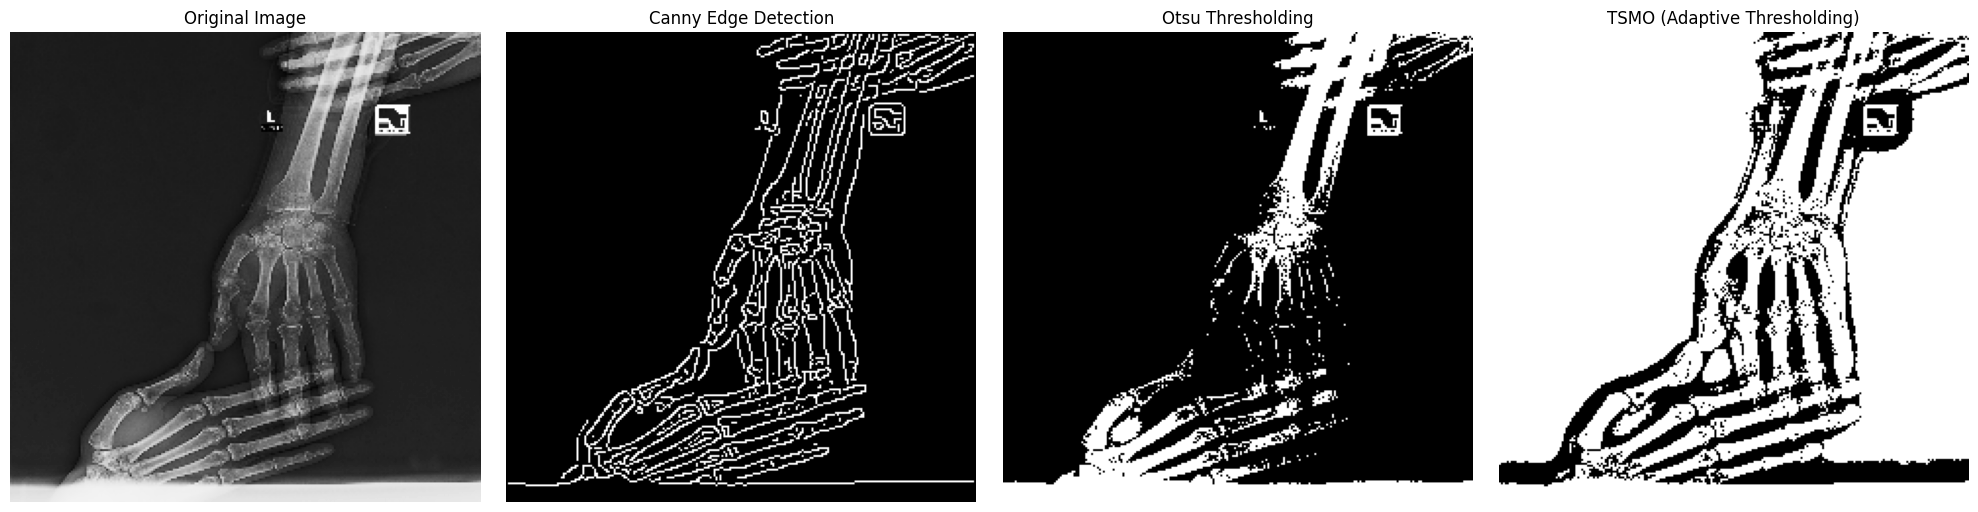

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Load the original and transformed datasets
# Replace the paths with the actual locations of your saved .npy files
Fractured = np.load("./augmented_data/augmented_images.npy")
canny_images = np.load("./augmented_data/canny_images.npy")
otsu_images = np.load("./augmented_data/otsu_images.npy")
tsmo_images = np.load("./augmented_data/tsmo_images.npy")

# Select an index for visualization
index = 0  # Change index to visualize different images

# Extract the images for visualization
original_image = Fractured[index, :, :, 0]
canny_image = canny_images[index, :, :, 0]
otsu_image = otsu_images[index, :, :, 0]
tsmo_image = tsmo_images[index, :, :, 0]

# Plot the results in a 1x4 grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Canny Edge Detection
axes[1].imshow(canny_image, cmap='gray')
axes[1].set_title("Canny Edge Detection")
axes[1].axis('off')

# Otsu Thresholding
axes[2].imshow(otsu_image, cmap='gray')
axes[2].set_title("Otsu Thresholding")
axes[2].axis('off')

# TSMO (Adaptive Thresholding)
axes[3].imshow(tsmo_image, cmap='gray')
axes[3].set_title("TSMO (Adaptive Thresholding)")
axes[3].axis('off')

plt.tight_layout()
plt.show()


# 3. Label 데이터 이진 class 분류
* 기존 class가 여러 개 인 문제가 있어 0보다 크면 1로 변경하고 나머진 0으로 두 개의 class 값만 남겨두었습니다.

array([0, 1])

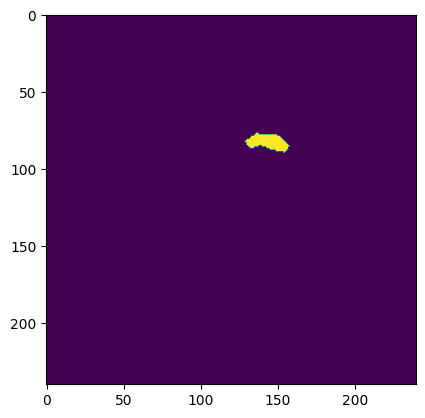

In [65]:
Mask = np.where(Mask > 0, 1, 0)
plt.imshow(Mask[0])
np.unique(Mask[0])

In [66]:
from tensorflow.keras.utils import to_categorical

Mask = to_categorical(Mask, num_classes=2)
print("Mask shape :", Mask.shape)

Mask shape : (2000, 240, 240, 2)


# 4. train, validation, test data 나누기
* train data : 60%
* validation data : 20%
* test data : 20%

In [92]:
from sklearn.model_selection import train_test_split

# 데이터 분할: train-test split
X_train, X_test, y_train, y_test = train_test_split(tsmo_images, Mask, test_size=0.2, random_state=42)

# 데이터 분할: train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 출력 형태 확인
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (1200, 240, 240, 1) (1200, 240, 240, 2)
Validation data shape: (400, 240, 240, 1) (400, 240, 240, 2)
Testing data shape: (400, 240, 240, 1) (400, 240, 240, 2)


# 5. Loss Function

### 5-1. Binary cross entropy + Dice loss

In [78]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Binary Crossentropy Dice Loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### 5-2. Dice loss + Focal loss

In [79]:
from tensorflow.keras import backend as K

def focal_loss(y_true, y_pred, gamma=5.0, alpha=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    cross_entropy = -y_true * tf.math.log(y_pred)
    loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(loss)

def combined_dice_focal_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

# 모델 학습되지 않아 내가 사용한 방법
* label 부분이 적어 모델이 전부 배경으로 인식해도 성능이 잘 나오니 전부 배경이라고 말해서 그러나 ?
 > focal loss 사용하여 작은 라벨에 가중치를 주어 라벨을 잘 보게 함.

* 데이터가 너무 적나 ?
 > ImageDataGenerator 사용하여 데이터 증강 후 학습
 
* 라벨 클래스 배경, 찾고자 하는 부분 2개 클래스로 나눠야 함.
 > 이전의 loss 값 1을 유지했다면 이렇게 하고 정상적인 loss 값이 나오지만 하나의 값이 유지됨.
 
* train data의 각 픽셀값이 0~255로 되어 있어 값이 커 계산량이 많아져서 그런가 ?
 > train data/255 해서 0~1 사이의 값으로 만들어 줌.
 
* 데이터는 적은데 모델이 너무 커서 모델을 학습하기엔 데이터가 너무 적나 ? (설정한 모델에 underfitting)
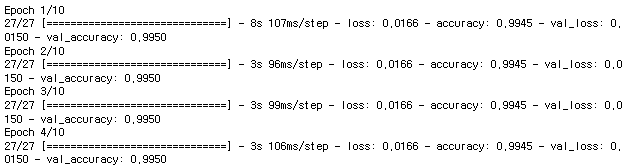
 > 모델의 파라미터 수를 1/10으로 줄여줌.

* 규제를 넣어 과적합 되지 않게 해줘야 하나 ?
 > L1, L2, dropout, early stopping 여기 까지 해주니 loss 값이 줄어드는 것을 확인할 수 있었는데 accuracy는 고정되어 있음.
 
* 작은 라벨에 더 집중하는 다른 LOSS FUNCTION을 사용해볼까?
 > Focal Loss

In [53]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# 각 이미지의 크기만 지정해 줍니다.
input_shape = (240, 240, 1)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.3)(pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.3)(pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.3)(pool3)

# Middle
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv4)

# Decoder
up5 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=-1)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up5)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv5)
conv5 = Dropout(0.3)(conv5)

up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=-1)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv6)
conv6 = Dropout(0.3)(conv6)

up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=-1)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv7)
conv7 = Dropout(0.3)(conv7)

# Output
outputs = Conv2D(2, (1, 1), activation='sigmoid')(conv7)  # 이진 분류의 경우 sigmoid 사용
model = Model(inputs=inputs, outputs=outputs)

# 모델 요약 정보
model.summary()

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습률 조정
learning_rate = 0.01
optimizer = Adam(learning_rate = learning_rate)

# 모델 컴파일 및 학습 (예: 'binary_crossentropy' 사용)
model.compile(optimizer=optimizer, loss=combined_dice_focal_loss, metrics=['accuracy'])

# 모델 학습 예시 (훈련 데이터 및 검증 데이터가 준비된 경우)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 240, 240, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 240, 240, 32)         9248      ['conv2d_15[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 120, 120, 32)         0         ['conv2d_16[0][0]']           
 g2D)                                                                                       

2024-11-05 07:39:33.522352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - 6s 129ms/step - loss: 0.4217 - accuracy: 0.9396 - val_loss: 0.1344 - val_accuracy: 0.9950
Epoch 2/100
14/14 [==============================] - 1s 88ms/step - loss: 0.0983 - accuracy: 0.9945 - val_loss: 0.0600 - val_accuracy: 0.9950
Epoch 3/100
14/14 [==============================] - 1s 90ms/step - loss: 0.0479 - accuracy: 0.9945 - val_loss: 0.0340 - val_accuracy: 0.9950
Epoch 4/100
14/14 [==============================] - 1s 90ms/step - loss: 0.0306 - accuracy: 0.9945 - val_loss: 0.0244 - val_accuracy: 0.9950
Epoch 5/100
14/14 [==============================] - 1s 91ms/step - loss: 0.0233 - accuracy: 0.9945 - val_loss: 0.0226 - val_accuracy: 0.9950
Epoch 6/100
14/14 [==============================] - 1s 90ms/step - loss: 0.0247 - accuracy: 0.9945 - val_loss: 0.0194 - val_accuracy: 0.9950
Epoch 7/100
14/14 [==============================] - 1s 89ms/step - loss: 0.0212 - accuracy: 0.9945 - val_loss: 0.0185 - val_accuracy: 0.9950
Epoch 8/100
14/14

In [57]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# 각 이미지의 크기만 지정해 줍니다.
input_shape = (240, 240, 1)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.3)(pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.3)(pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.3)(pool3)

# Middle
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv4)

# Decoder
up5 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=-1)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up5)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv5)
conv5 = Dropout(0.3)(conv5)

up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=-1)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv6)
conv6 = Dropout(0.3)(conv6)

up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=-1)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv7)
conv7 = Dropout(0.3)(conv7)

# Output
outputs = Conv2D(2, (1, 1), activation='sigmoid')(conv7)  # 이진 분류의 경우 sigmoid 사용
model = Model(inputs=inputs, outputs=outputs)

# 모델 요약 정보
model.summary()

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습률 조정
learning_rate = 0.01
optimizer = Adam(learning_rate = learning_rate)

# 모델 컴파일 및 학습 (예: 'binary_crossentropy' 사용)
model.compile(optimizer=optimizer, loss=combined_dice_focal_loss, metrics=['accuracy'])

# 모델 학습 예시 (훈련 데이터 및 검증 데이터가 준비된 경우)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 240, 240, 32)         320       ['input_4[0][0]']             
                                                                                                  
 conv2d_46 (Conv2D)          (None, 240, 240, 32)         9248      ['conv2d_45[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 120, 120, 32)         0         ['conv2d_46[0][0]']           
 g2D)                                                                                       

2024-11-05 07:43:51.985947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - 6s 137ms/step - loss: 7.6943 - accuracy: 0.9845 - val_loss: 1.3250 - val_accuracy: 0.9950
Epoch 2/100
14/14 [==============================] - 1s 102ms/step - loss: 1.2835 - accuracy: 0.9945 - val_loss: 1.1758 - val_accuracy: 0.9950
Epoch 3/100
14/14 [==============================] - 1s 87ms/step - loss: 1.0736 - accuracy: 0.9945 - val_loss: 0.9548 - val_accuracy: 0.9950
Epoch 4/100
14/14 [==============================] - 1s 88ms/step - loss: 0.8790 - accuracy: 0.9945 - val_loss: 0.7962 - val_accuracy: 0.9950
Epoch 5/100
14/14 [==============================] - 1s 85ms/step - loss: 0.7459 - accuracy: 0.9945 - val_loss: 0.6911 - val_accuracy: 0.9950
Epoch 6/100
14/14 [==============================] - 1s 87ms/step - loss: 0.6574 - accuracy: 0.9945 - val_loss: 0.6202 - val_accuracy: 0.9950
Epoch 7/100
14/14 [==============================] - 1s 86ms/step - loss: 0.5967 - accuracy: 0.9945 - val_loss: 0.5704 - val_accuracy: 0.9950
Epoch 8/100
14/1

# 모델의 깊이를 깊게

In [58]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 입력 형태
input_shape = (240, 240, 1)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.3)(pool1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.3)(pool2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.3)(pool3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(0.3)(pool4)

# Middle
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv5)

# Decoder
up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=-1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv6)
conv6 = Dropout(0.3)(conv6)

up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=-1)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv7)
conv7 = Dropout(0.3)(conv7)

up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv8)
conv8 = Dropout(0.3)(conv8)

up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=-1)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv9)
conv9 = Dropout(0.3)(conv9)

# Output
outputs = Conv2D(2, (1, 1), activation='sigmoid')(conv9)
model = Model(inputs=inputs, outputs=outputs)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 옵티마이저와 학습률 설정
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=combined_dice_focal_loss, metrics=['accuracy'])

# 모델 요약 정보 출력
model.summary()

# 모델 학습 (훈련 데이터와 검증 데이터 준비)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 240, 240, 64)         640       ['input_5[0][0]']             
                                                                                                  
 conv2d_61 (Conv2D)          (None, 240, 240, 64)         36928     ['conv2d_60[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 120, 120, 64)         0         ['conv2d_61[0][0]']           
 ng2D)                                                                                      

2024-11-05 07:48:09.178605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - 107s 2s/step - loss: 49.6000 - accuracy: 0.9839 - val_loss: 41.2783 - val_accuracy: 0.9950
Epoch 2/100
14/14 [==============================] - 3s 209ms/step - loss: 45.3744 - accuracy: 0.9945 - val_loss: 40.6950 - val_accuracy: 0.9950
Epoch 3/100
14/14 [==============================] - 3s 210ms/step - loss: 44.9752 - accuracy: 0.9945 - val_loss: 40.4442 - val_accuracy: 0.9950
Epoch 4/100
14/14 [==============================] - 3s 211ms/step - loss: 44.7902 - accuracy: 0.9945 - val_loss: 40.3216 - val_accuracy: 0.9950
Epoch 5/100
14/14 [==============================] - 3s 209ms/step - loss: 44.6946 - accuracy: 0.9945 - val_loss: 40.2546 - val_accuracy: 0.9950
Epoch 6/100
14/14 [==============================] - 3s 210ms/step - loss: 44.6388 - accuracy: 0.9945 - val_loss: 40.2137 - val_accuracy: 0.9950
Epoch 7/100
14/14 [==============================] - 3s 209ms/step - loss: 44.6071 - accuracy: 0.9945 - val_loss: 40.1917 - val_accuracy: 0.995

# 깊고 class 가중치

In [93]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 입력 형태
input_shape = (240, 240, 1)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.3)(pool1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.3)(pool2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.3)(pool3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(0.3)(pool4)

# Middle
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv5)
conv5 = BatchNormalization()(conv5)

# Decoder
up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=-1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Dropout(0.3)(conv6)

up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=-1)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = Dropout(0.3)(conv7)

up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = Dropout(0.3)(conv8)

up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=-1)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Dropout(0.3)(conv9)

# Output
outputs = Conv2D(2, (1, 1), activation='sigmoid')(conv9)
model = Model(inputs=inputs, outputs=outputs)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습률 조정 콜백
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 옵티마이저와 학습률 설정
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=combined_dice_focal_loss, metrics=['accuracy'])

# 모델 학습 (훈련 데이터와 검증 데이터 준비)
class_weights = {0: 1.0, 1: 100.0}
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, class_weight=class_weights, callbacks=[early_stopping, reduce_lr])


Epoch 1/100


2024-11-29 10:05:12.699113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


38/38 [==============================] - 23s 344ms/step - loss: 5.3703 - accuracy: 0.6943 - val_loss: 4.0832 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 2/100
38/38 [==============================] - 12s 321ms/step - loss: 3.6944 - accuracy: 0.8000 - val_loss: 2.7299 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 3/100
38/38 [==============================] - 12s 322ms/step - loss: 2.6246 - accuracy: 0.8276 - val_loss: 1.8993 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 4/100
38/38 [==============================] - 12s 326ms/step - loss: 1.9452 - accuracy: 0.8404 - val_loss: 1.3856 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 5/100
38/38 [==============================] - 12s 324ms/step - loss: 1.5141 - accuracy: 0.8504 - val_loss: 1.0648 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 6/100
38/38 [==============================] - 12s 326ms/step - loss: 1.2342 - accuracy: 0.8628 - val_loss: 0.8632 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 7/100
38/38 [===========================

In [85]:
# 예측된 클래스와 실제 클래스를 1차원으로 변환
# y_pred의 클래스 인덱스 예측
y_pred_classes = np.argmax(y_pred, axis=-1)  # (num_samples, 240, 240)

# y_test의 클래스 인덱스
y_test_classes = np.argmax(y_test, axis=-1)  # (num_samples, 240, 240)

In [107]:
y_pred_classes.shape

(144, 240, 240)

In [110]:
y_test_classes.shape

(144, 240, 240)

In [109]:
# y_test의 클래스 인덱스
y_test_classes = np.argmax(y_test_classes, axis=-1)  # (num_samples, 240, 240)

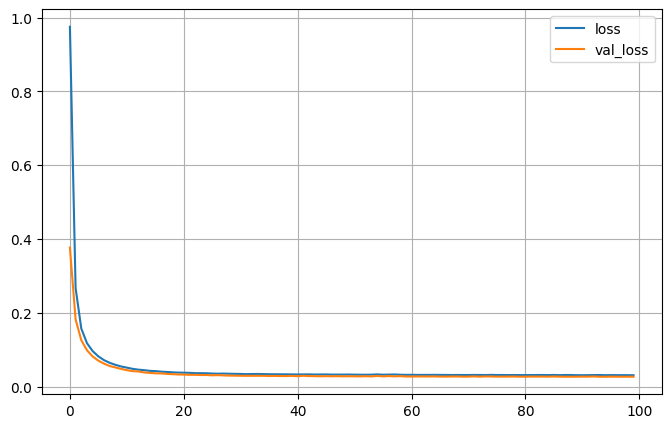

(<matplotlib.legend.Legend at 0x7f11e0639d60>, None, None)

In [14]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

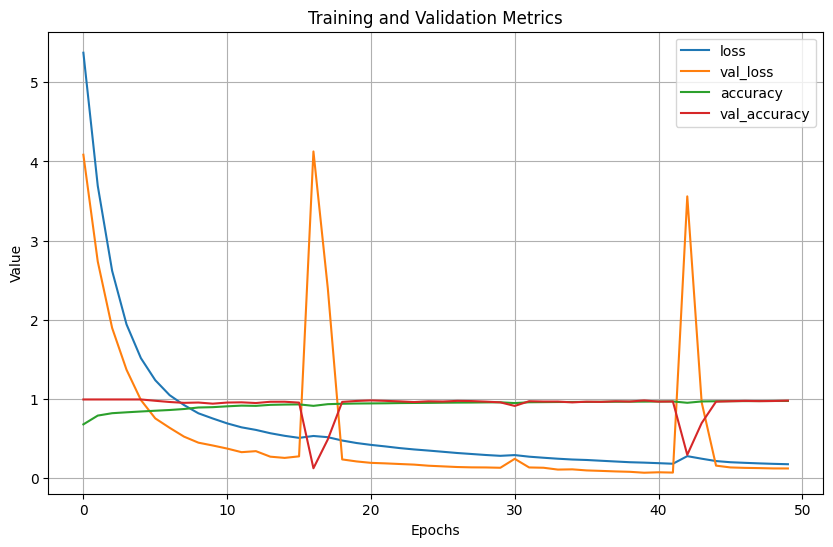

In [88]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']  # Plot 대상 추가
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
for each in plot_target:
    plt.plot(history.history[each], label=each)  # 각 메트릭에 대해 그래프 생성
plt.legend()  # 범례 표시
plt.grid()    # 격자 표시
plt.title('Training and Validation Metrics')  # 제목 추가
plt.xlabel('Epochs')  # x축 라벨
plt.ylabel('Value')   # y축 라벨
plt.show()


# Original image 결과 확인

5/5 [==============================] - 0s 26ms/step
Confusion Matrix:
 [[8249527   44873]
 [  44873 8249527]]
Precision: 0.9946
Recall: 0.9946
F1 Score: 0.9946


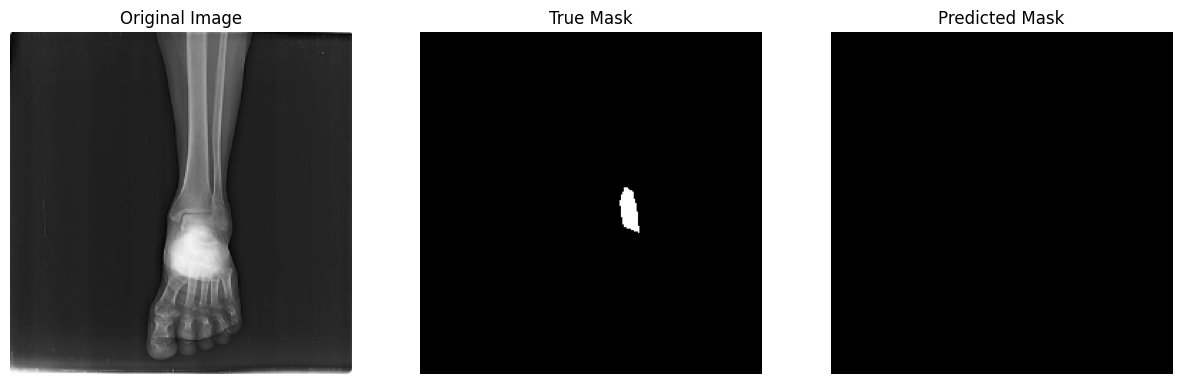

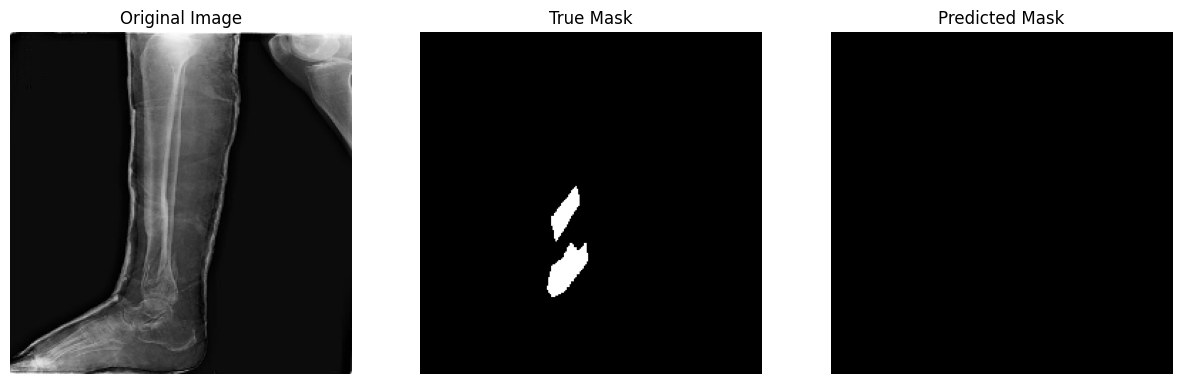

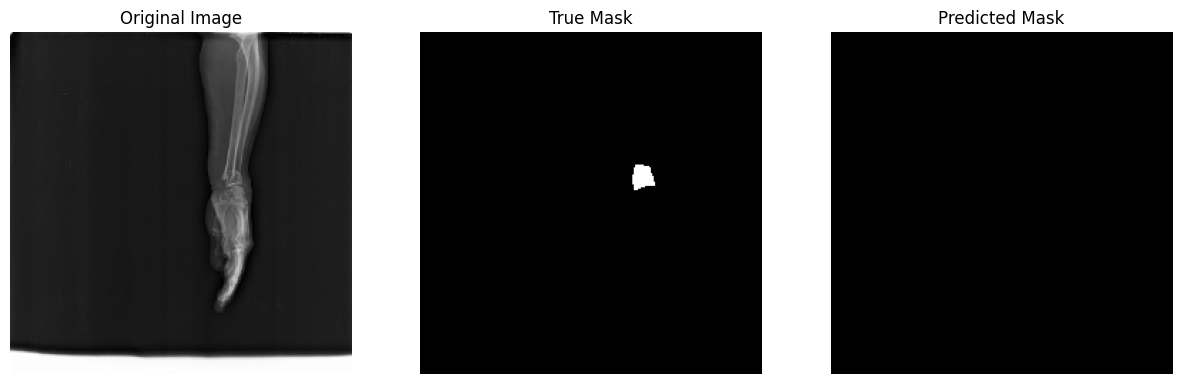

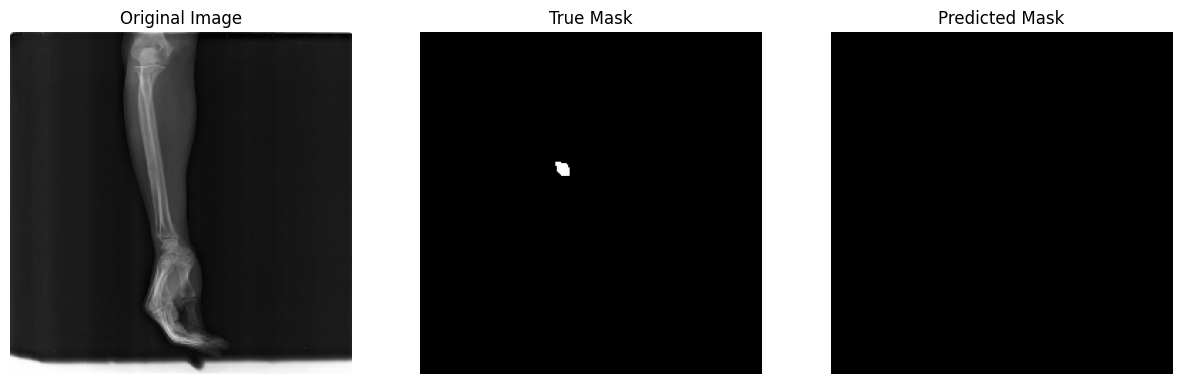

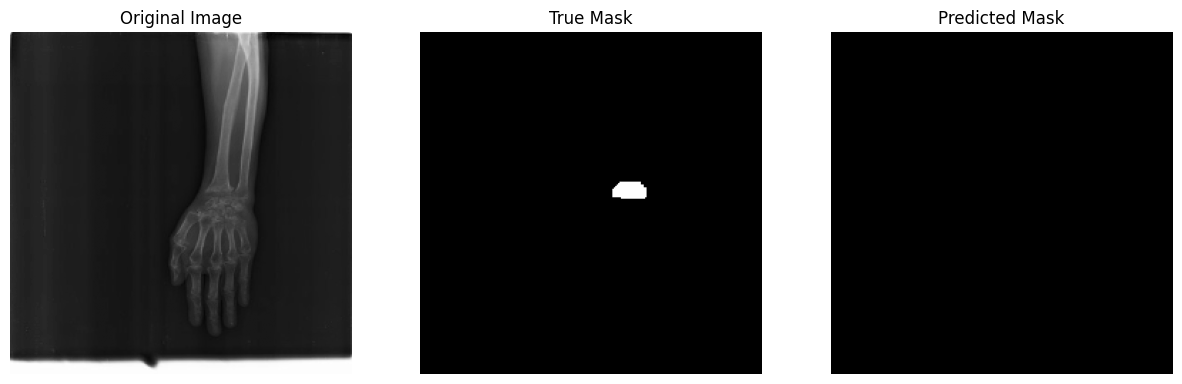

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Test 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# 예측 및 실제 값 이진화 (threshold=0.5 이상이면 1, 아니면 0)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test_binary = (y_test > 0.5).astype(np.uint8)

# Flatten하여 혼동 행렬 계산
y_pred_flat = y_pred_binary.flatten()
y_test_flat = y_test_binary.flatten()

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print("Confusion Matrix:\n", conf_matrix)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# 테스트 데이터 시각화
num_visualizations = 5  # 시각화할 테스트 데이터 개수
for i in range(num_visualizations):
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].reshape(240, 240), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    # 실제 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(y_test[i], axis=-1), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")
    
    # 예측 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(y_pred[i], axis=-1), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()


# OTSU 변환 결과 확인

13/13 [==============================] - 1s 57ms/step
Confusion Matrix:
 [[22906035   133965]
 [  133965 22906035]]
Precision: 0.9942
Recall: 0.9942
F1 Score: 0.9942


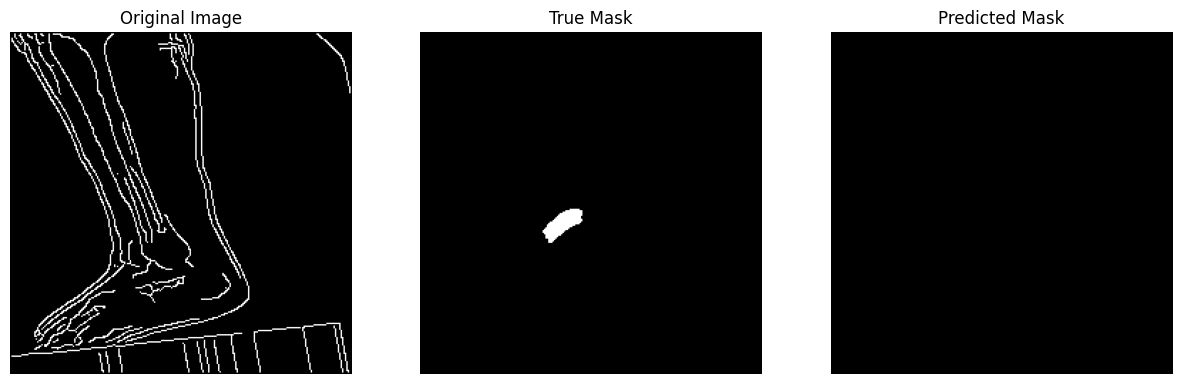

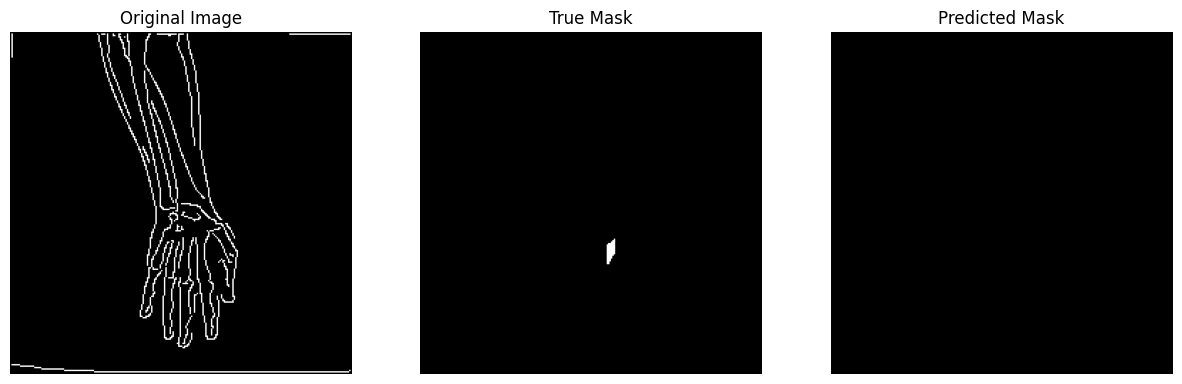

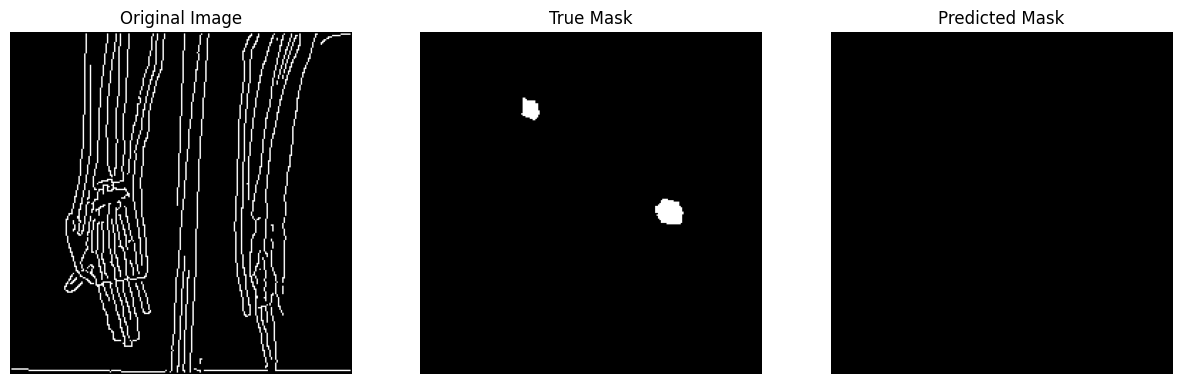

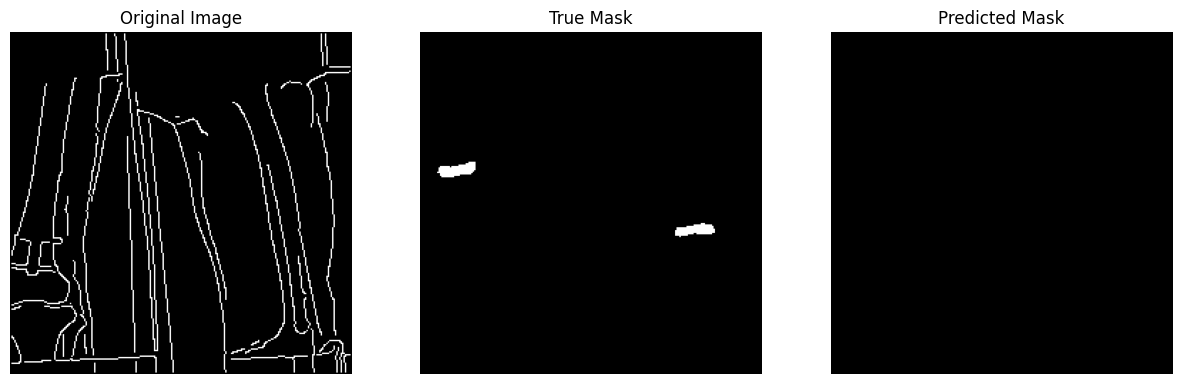

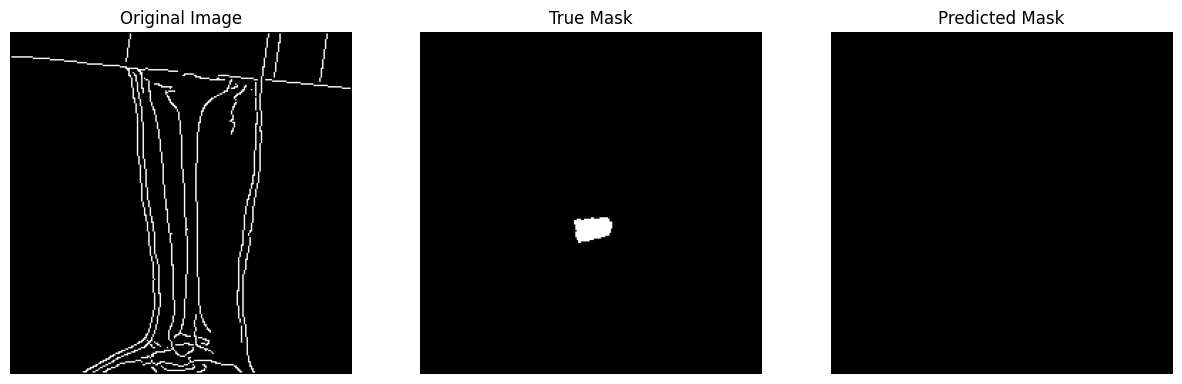

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Test 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# 예측 및 실제 값 이진화 (threshold=0.5 이상이면 1, 아니면 0)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test_binary = (y_test > 0.5).astype(np.uint8)

# Flatten하여 혼동 행렬 계산
y_pred_flat = y_pred_binary.flatten()
y_test_flat = y_test_binary.flatten()

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print("Confusion Matrix:\n", conf_matrix)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# 테스트 데이터 시각화
num_visualizations = 5  # 시각화할 테스트 데이터 개수
for i in range(num_visualizations):
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].reshape(240, 240), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    # 실제 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(y_test[i], axis=-1), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")
    
    # 예측 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(y_pred[i], axis=-1), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()


# TSMO 변환 결과 확인

13/13 [==============================] - 1s 55ms/step
Confusion Matrix:
 [[22634116   405884]
 [  131446 22908554]]
Precision: 0.9826
Recall: 0.9943
F1 Score: 0.9884


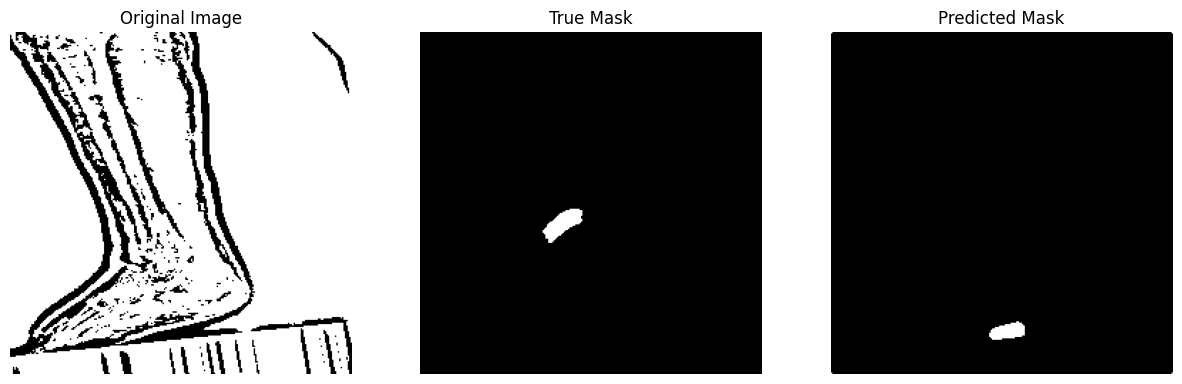

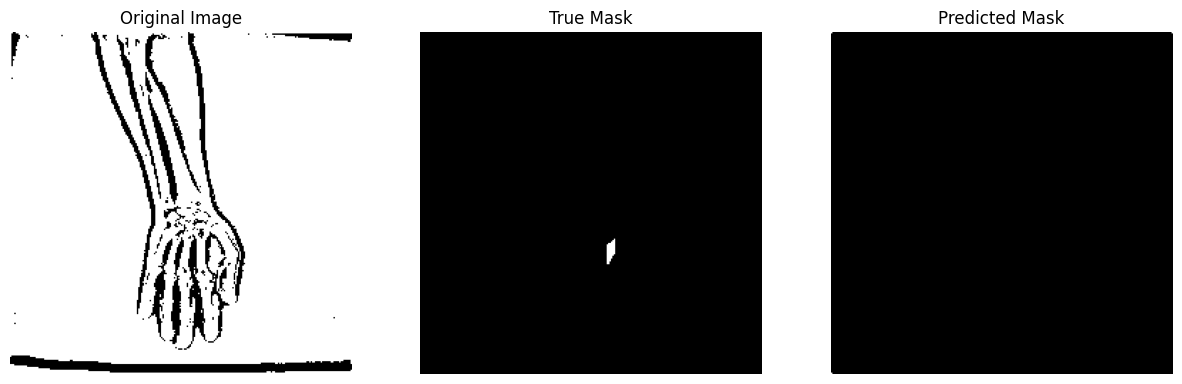

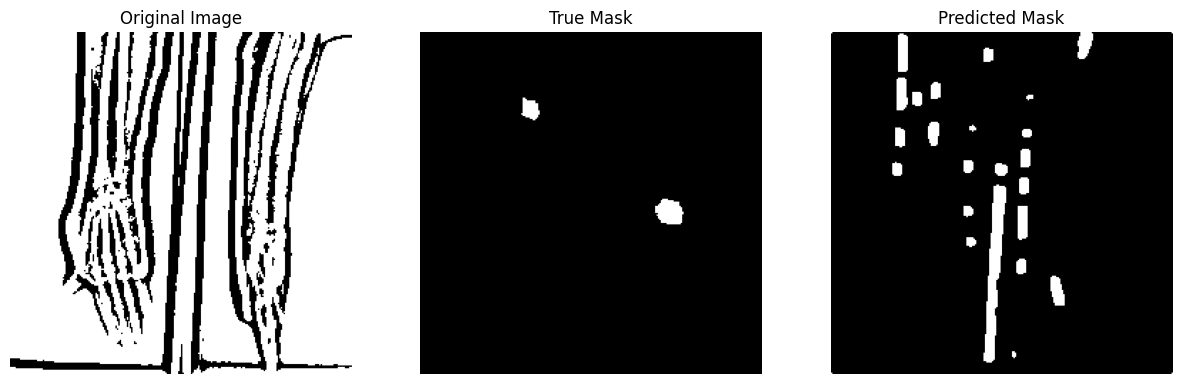

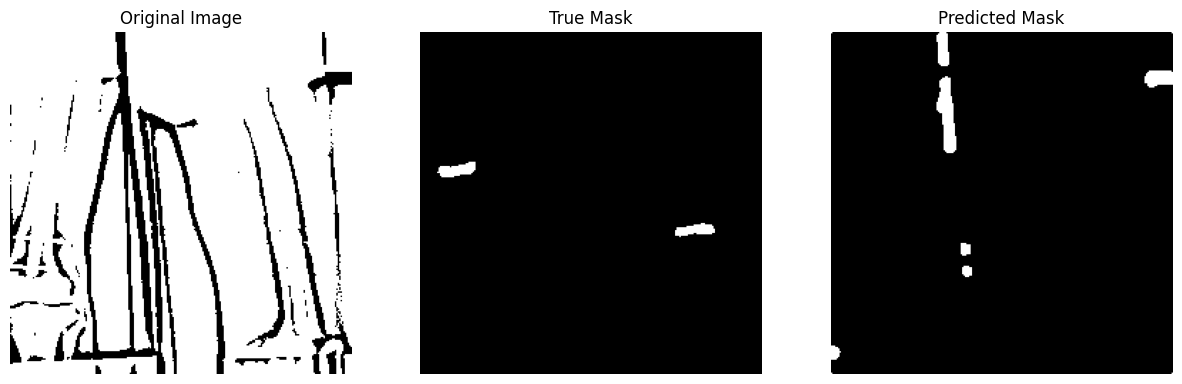

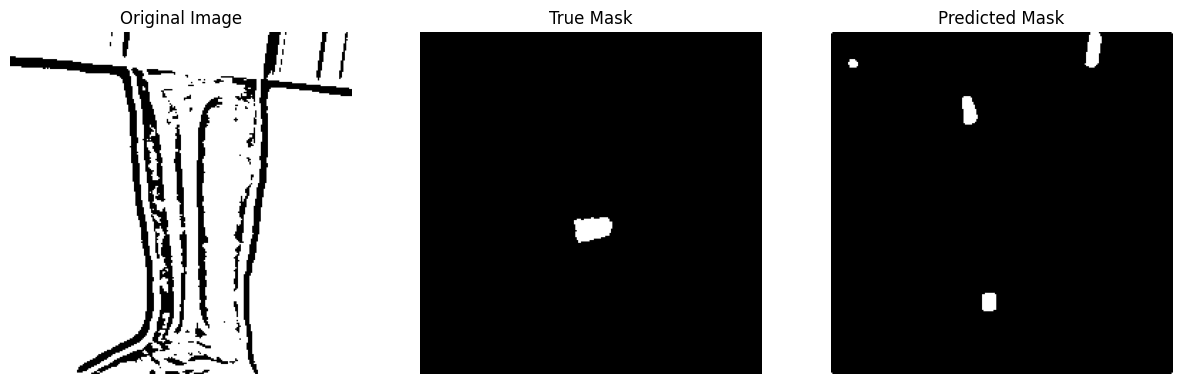

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Test 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# 예측 및 실제 값 이진화 (threshold=0.5 이상이면 1, 아니면 0)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test_binary = (y_test > 0.5).astype(np.uint8)

# Flatten하여 혼동 행렬 계산
y_pred_flat = y_pred_binary.flatten()
y_test_flat = y_test_binary.flatten()

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print("Confusion Matrix:\n", conf_matrix)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# 테스트 데이터 시각화
num_visualizations = 5  # 시각화할 테스트 데이터 개수
for i in range(num_visualizations):
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].reshape(240, 240), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    # 실제 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(y_test[i], axis=-1), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")
    
    # 예측 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(y_pred[i], axis=-1), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()


13/13 [==============================] - 1s 57ms/step
Confusion Matrix:
 [[22903625   136375]
 [  133909 22906091]]
Precision: 0.9941
Recall: 0.9942
F1 Score: 0.9941


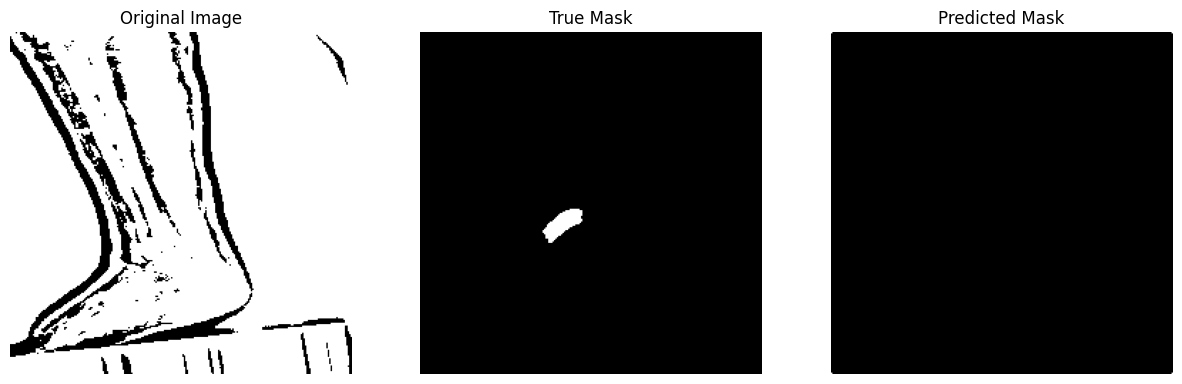

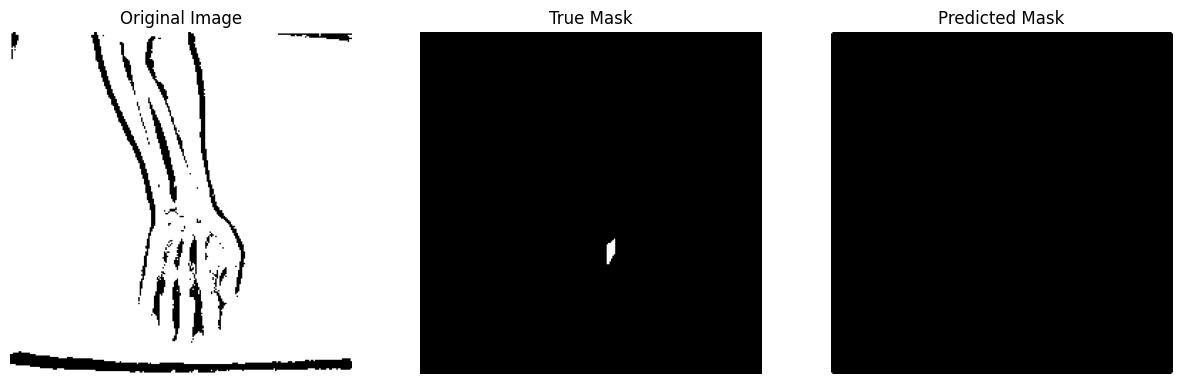

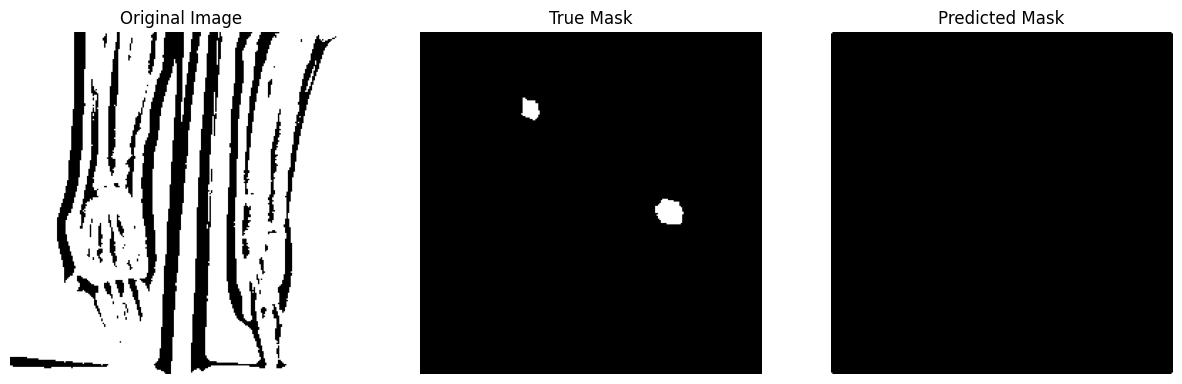

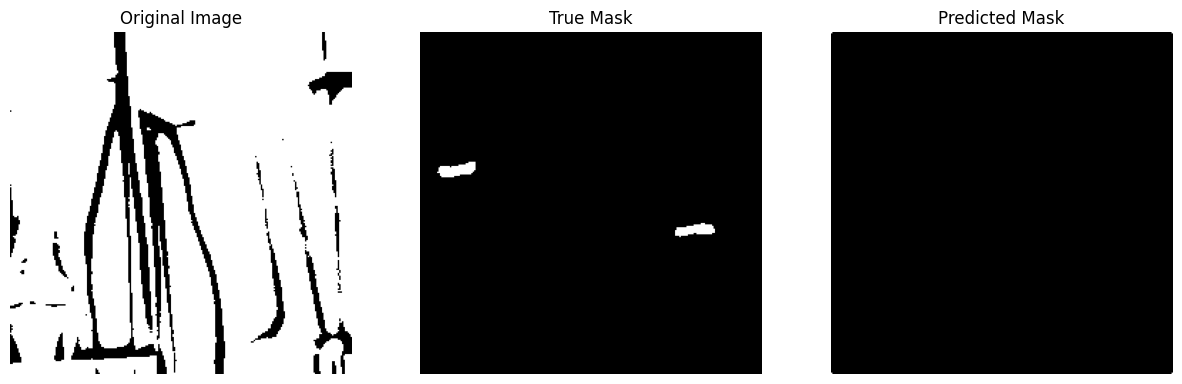

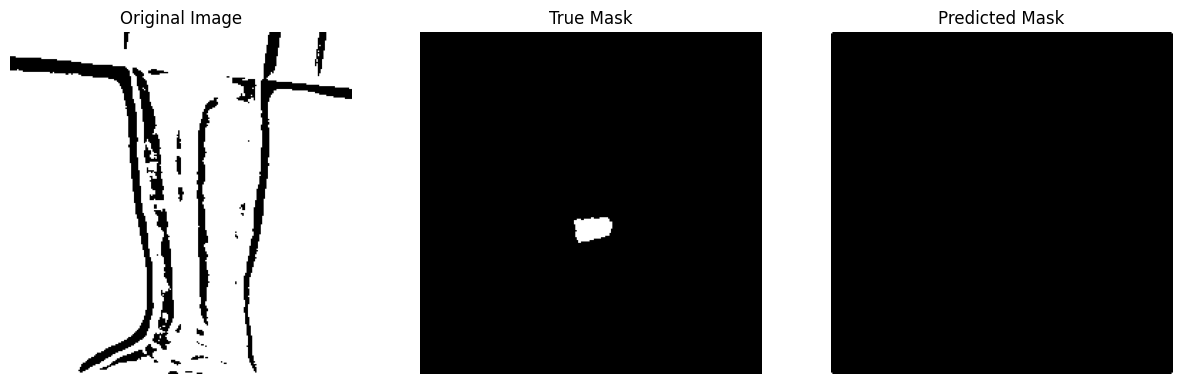

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Test 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# 예측 및 실제 값 이진화 (threshold=0.5 이상이면 1, 아니면 0)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test_binary = (y_test > 0.5).astype(np.uint8)

# Flatten하여 혼동 행렬 계산
y_pred_flat = y_pred_binary.flatten()
y_test_flat = y_test_binary.flatten()

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print("Confusion Matrix:\n", conf_matrix)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# 테스트 데이터 시각화
num_visualizations = 5  # 시각화할 테스트 데이터 개수
for i in range(num_visualizations):
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].reshape(240, 240), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    # 실제 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(y_test[i], axis=-1), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")
    
    # 예측 마스크: 2채널을 단일 채널로 변환
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(y_pred[i], axis=-1), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()
